# Machine Learning Course Project (End-to-End)

> **Course:** Machine Learning

## Team Members
- **Mohamed Mostafa** — **23101594**
- **Marwan Khaled** — **23101599**
- **Mohamed Adel** — **23101899**

> **Date:** December 2025

> This notebook is submission-ready: it loads a dirty real-world dataset, cleans and analyzes it, builds **one classification** and **one regression** model, compares multiple algorithms (with/without scaling and normalization), and exports a **PDF report** + a **ZIP** of all deliverables.

## Table of Contents
1. Part 1 — Problem Understanding
2. Part 2 — Data Collection & Dataset Description
3. Part 3 — Data Cleaning & Refinement
4. Part 4 — Exploratory Data Analysis (EDA)
5. Part 5 — Data Visualization (8 required plots)
6. Part 6 — Machine Learning (Classification + Regression)
7. Deliverables — PDF Report + ZIP Package

# Part 1 — Problem Understanding
## 1.1 Problem Domain (Unique Domain Choice)
**Domain:** *Data-driven content acquisition and release strategy for a niche streaming platform focusing on long-tail cinema.*

> Many beginner projects predict “house price” or “Titanic survival.” Here we instead study **movie performance signals** (popularity, votes, genres, language, runtime, release timing) to support decisions like:
- Which types of films are likely to be **high-rated** (quality signal)?
- Which films are likely to generate **higher revenue** (commercial signal)?

## 1.2 Research Goal
- **Goal (classification):** Predict whether a movie is **High Rated** (e.g., IMDb/TMDb-style rating $\ge 7.5$) using metadata available early in the lifecycle.
- **Goal (regression):** Predict **log-revenue** (a continuous value) for movies with reported revenue, using the same metadata.

## 1.3 Why This Matters (Academic Justification)
- Streaming services face budget constraints and uncertainty; decisions must be made using incomplete metadata.
- The project supports **resource allocation** (marketing focus), **portfolio balance** (genre/language mix), and **risk management** (avoid investing heavily in low-ROI profiles).

## 1.4 Target Variables
- **Classification target:** `is_high_rated` (binary) derived from `vote_average` using a threshold (defined later).
- **Regression target:** `log_revenue = log(1 + revenue)` for movies with `revenue > 0` (helps with heavy skew).

In [1]:
# Part 0 — Setup (Imports, Settings, Paths)
import os
import re
import ast
import textwrap
from datetime import datetime
from pathlib import Path
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, median_absolute_error, r2_score,
    ConfusionMatrixDisplay,
 )

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths (robust to different working directories)
PROJECT_DIR = Path.cwd().resolve()
DATA_PATH = PROJECT_DIR / "Top_10000_Movies.csv"
if not DATA_PATH.exists():
    matches = list(PROJECT_DIR.rglob("Top_10000_Movies.csv"))
    if matches:
        DATA_PATH = matches[0].resolve()
        PROJECT_DIR = DATA_PATH.parent
FIG_DIR = PROJECT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")
print("Project directory:", PROJECT_DIR)
print("Dataset path:", DATA_PATH)
print("Dataset exists:", DATA_PATH.exists())

Project directory: /content
Dataset path: /content/Top_10000_Movies.csv
Dataset exists: False


In [2]:
# Part 2 — Data Collection (Load Dataset)
from pandas.errors import ParserError

def load_csv_safe(path):
    """Load a dirty CSV robustly (handles malformed long-text rows)."""
    try:
        return pd.read_csv(path)
    except ParserError:
        return pd.read_csv(path, engine="python")
    except Exception:
        return pd.read_csv(path, engine="python", on_bad_lines="skip")

df_raw = load_csv_safe(DATA_PATH)
print("Rows, Cols:", df_raw.shape)
display(df_raw.head(3))
display(df_raw.sample(3, random_state=RANDOM_STATE))

# Quick schema overview
display(df_raw.dtypes)
display(df_raw.describe(include="all").T.head(20))

Rows, Cols: (10014, 13)


,Unnamed: 0,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,0,580489.0,en,Venom: Let There Be Carnage,5401.308,2021-09-30,6.8,1736.0,"['Science Fiction', 'Action', 'Adventure']",After finding a host body in investigative rep...,424000000.0,97.0,NaN
1,1,524434.0,en,Eternals,3365.535,2021-11-03,7.1,622.0,"['Action', 'Adventure', 'Science Fiction', 'Fa...",The Eternals are a team of ancient aliens who ...,165000000.0,157.0,In the beginning...
2,2,438631.0,en,Dune,2911.423,2021-09-15,8.0,3632.0,"['Action', 'Adventure', 'Science Fiction']","Paul Atreides, a brilliant and gifted young ma...",331116356.0,155.0,"Beyond fear, destiny awaits."


,Unnamed: 0,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
1617,1617,407439.0,en,Mary Magdalene,44.656,2018-03-15,6.3,413.0,"['Drama', 'History']","In the first century, free-spirited Mary Magda...",10940439.0,120.0,Her story will be told
3918,3914,297608.0,en,The Taking of Deborah Logan,20.068,2014-10-21,6.3,820.0,"['Horror', 'Mystery', 'Thriller']",What starts as a poignant medical documentary ...,0.0,90.0,Evil lives within you
2168,2164,161326.0,en,Dangerous Worry Dolls,29.211,2008-01-22,3.8,14.0,"['Horror', 'Science Fiction']",While serving time in a brutal women's detenti...,0.0,75.0,NaN


Unnamed: 0            object
id                   float64
original_language     object
original_title        object
popularity           float64
release_date          object
vote_average         float64
vote_count           float64
genre                 object
overview              object
revenue              float64
runtime              float64
tagline               object
dtype: object

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,10014,10014,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,10002.0,NaN,NaN,NaN,250003.082683,261732.329571,0.0,11864.5,144312.0,451406.0,893478.0
original_language,10002,49,en,7798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,10001,9757,Polaroid,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,10000.0,NaN,NaN,NaN,34.516871,100.693958,6.269,11.908,17.488,29.62625,5401.308
release_date,9962,5727,2021-11-11,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vote_average,10000.0,NaN,NaN,NaN,6.29875,1.43426,0.0,5.9,6.5,7.1,9.5
vote_count,10000.0,NaN,NaN,NaN,1315.0849,2501.899103,0.0,118.0,425.5,1297.25,30184.0
genre,10000,2314,['Drama'],533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overview,9900,9895,Plot unknown.,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2 — Data Collection & Dataset Description
## 2.1 Dataset Source (Public)
This dataset (`Top_10000_Movies.csv`) contains movie metadata such as `popularity`, `vote_average`, `vote_count`, `revenue`, `runtime`, and text fields (`overview`, `tagline`).

> **Source note:** The column names and semantics match **TMDb (The Movie Database)** public movie metadata fields (e.g., `popularity`, `vote_average`, `vote_count`, `revenue`). The dataset is commonly created by extracting from TMDb's public API and publishing it (e.g., as a CSV on open-data platforms / Kaggle).

## 2.2 Why This Dataset Is Appropriate
- **Size requirement:** $\ge 10,000$ rows (this file has ~10k).
- **Feature requirement:** $\ge 10$ columns (this file has 13).
- **Mixed data types:** numerical (`popularity`, `revenue`, `runtime`), categorical (`original_language`), semi-structured categorical (`genre` list), temporal (`release_date`), and text (`overview`, `tagline`).
- **Dirty data:** contains missing text values (blank `tagline`), zero revenues (often a missing/unknown proxy), potential duplicates, inconsistent formatting (genres stored as stringified lists), and outliers (extreme popularity/revenue).

## 2.3 Column Dictionary (to be generated programmatically below)
We will produce an academic description of each column after inspecting the dataset schema.

**Citation note (important for submission):** if your course requires a precise URL, cite the exact public page you obtained this CSV from. The schema strongly matches TMDb-style fields; the included `download_dataset.py` is a template for recreating the dataset via a public movie-metadata API if needed.

In [3]:
# Dataset profiling: missingness, duplicates, basic anomalies
df = df_raw.copy()

# Standardize column names just in case (keep original meaning)
df.columns = [c.strip() for c in df.columns]

print("Shape:", df.shape)
print("Columns:", list(df.columns))

missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df)).round(4)
profile = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct, "dtype": df.dtypes.astype(str)})
display(profile)

# Potential duplicates (full-row and key-based)
full_dupes = df.duplicated().sum()
key_dupes = df.duplicated(subset=["id", "original_title", "release_date"]).sum() if set(["id","original_title","release_date"]).issubset(df.columns) else None
print("Full-row duplicates:", full_dupes)
print("Key-based duplicates (id,title,date):", key_dupes)

# Quick dirty signals
print("Blank tagline rows:", (df.get("tagline").fillna("").str.strip() == "").sum() if "tagline" in df.columns else "N/A")
print("Zero revenue rows:", (df.get("revenue", pd.Series(dtype=float)) == 0).sum() if "revenue" in df.columns else "N/A")

# Column dictionary (academic-style)
column_dictionary = {
    "Unnamed index column (first column)": "A row index carried over from a previous export; not a true feature.",
    "id": "Movie identifier (typically from the source system).",
    "original_language": "Original language code of the movie (categorical).",
    "original_title": "Original movie title (text/categorical).",
    "popularity": "Platform-specific popularity score (continuous).",
    "release_date": "Release date (YYYY-MM-DD), later parsed to year/decade.",
    "vote_average": "Average user rating score (continuous, typically 0–10).",
    "vote_count": "Number of user votes (count variable).",
    "genre": "Genres as a stringified Python list (semi-structured categorical).",
    "overview": "Short plot summary text.",
    "revenue": "Reported revenue (numeric; often 0 if missing/unreported).",
    "runtime": "Runtime in minutes (numeric).",
    "tagline": "Marketing tagline text (often missing).",
}
display(pd.DataFrame({"column": df.columns}))
print("\nSuggested dictionary (interpretation):")
for col in df.columns:
    msg = column_dictionary.get(col, "(No manual description; see dtypes/EDA)")
    print(f"- {col}: {msg}")

Shape: (10014, 13)
Columns: ['Unnamed: 0', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'vote_average', 'vote_count', 'genre', 'overview', 'revenue', 'runtime', 'tagline']


,missing_count,missing_pct,dtype
Unnamed: 0,0,0.0000,object
genre,14,0.0014,object
id,12,0.0012,float64
original_language,12,0.0012,object
original_title,13,0.0013,object
overview,114,0.0114,object
popularity,14,0.0014,float64
release_date,52,0.0052,object
revenue,16,0.0016,float64
runtime,25,0.0025,float64


Full-row duplicates: 0
Key-based duplicates (id,title,date): 11
Blank tagline rows: 2935
Zero revenue rows: 4656


,column
0,Unnamed: 0
1,id
2,original_language
3,original_title
4,popularity
5,release_date
6,vote_average
7,vote_count
8,genre
9,overview



Suggested dictionary (interpretation):
- Unnamed: 0: (No manual description; see dtypes/EDA)
- id: Movie identifier (typically from the source system).
- original_language: Original language code of the movie (categorical).
- original_title: Original movie title (text/categorical).
- popularity: Platform-specific popularity score (continuous).
- release_date: Release date (YYYY-MM-DD), later parsed to year/decade.
- vote_average: Average user rating score (continuous, typically 0–10).
- vote_count: Number of user votes (count variable).
- genre: Genres as a stringified Python list (semi-structured categorical).
- overview: Short plot summary text.
- revenue: Reported revenue (numeric; often 0 if missing/unreported).
- runtime: Runtime in minutes (numeric).
- tagline: Marketing tagline text (often missing).


# Part 3 — Data Cleaning & Refinement
We will perform all required cleaning operations:
1. Identify/handle missing values and explain likely causes.
2. Remove irrelevant variables for modeling (while keeping them for EDA where useful).
3. Remove duplicates.
4. Detect and remove outliers using box plots + IQR rule.
5. Handle blank spaces/inconsistent formatting (casing, string lists).
6. Arrange data logically; ensure correct types, grouping, and ordering.
7. Apply **Scaling** and **Normalization** as separate experiments (later used in modeling comparisons).

In [4]:
# 3.1 Standardize formatting + parse semi-structured fields
df_clean = df_raw.copy()

# Remove irrelevant export index column if present
for col in list(df_clean.columns):
    if col.lower().startswith("unnamed") or col.strip() == "":
        df_clean = df_clean.drop(columns=[col])

# Trim whitespace in object columns
obj_cols = df_clean.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# Normalize casing for language code
if "original_language" in df_clean.columns:
    df_clean["original_language"] = df_clean["original_language"].str.lower().replace({"nan": np.nan})

# Parse release_date
df_clean["release_date"] = pd.to_datetime(df_clean["release_date"], errors="coerce")
df_clean["release_year"] = df_clean["release_date"].dt.year
df_clean["release_decade"] = (df_clean["release_year"] // 10 * 10).astype("Int64")

# Parse genres (stringified list) -> list[str] + main genre
def parse_genre_list(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s in {"", "nan", "None"}:
        return []
    try:
        lst = ast.literal_eval(s)
        if isinstance(lst, list):
            # Clean each entry
            return [str(g).strip().title() for g in lst if str(g).strip() not in {"", "nan"}]
        return []
    except Exception:
        # If malformed, attempt simple split fallback
        s2 = re.sub(r"[\[\]\']", "", s)
        parts = [p.strip() for p in s2.split(",") if p.strip()]
        return [p.title() for p in parts]

if "genre" in df_clean.columns:
    df_clean["genre_list"] = df_clean["genre"].apply(parse_genre_list)
    df_clean["genre_count"] = df_clean["genre_list"].apply(len)
    df_clean["genre_main"] = df_clean["genre_list"].apply(lambda g: g[0] if len(g) else "Unknown")

# Text-derived features (keeps code within standard libraries)
for txt_col in ["overview", "tagline", "original_title"]:
    if txt_col in df_clean.columns:
        df_clean[txt_col] = df_clean[txt_col].replace({"nan": ""})
        df_clean[f"{txt_col}_len"] = df_clean[txt_col].fillna("").astype(str).str.len()

# 3.2 Missing values: identify + handle
missing_before = df_clean.isna().sum().sort_values(ascending=False)
display(missing_before[missing_before > 0])

# Why missing? (practical explanation)
print("\nInterpretation of missingness (typical for movie metadata):")
print("- release_date missing: older/incomplete records or parsing errors")
print("- runtime missing: not reported for some records")
print("- tagline/overview blank: marketing text absent or not translated")
print("- revenue == 0: frequently indicates missing/unreported revenue rather than true zero")

# Convert numeric columns; coerce errors to NaN
numeric_candidates = ["popularity", "vote_average", "vote_count", "revenue", "runtime", "release_year"]
for c in numeric_candidates:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

# Fill categorical missing values
for c in ["original_language", "genre_main"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].fillna("unknown").replace({"": "unknown"})

# Fill numeric missing values (median is robust for skew)
for c in ["popularity", "vote_average", "vote_count", "runtime", "release_year"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())

# Handle blank strings consistently
for c in ["tagline", "overview", "original_title"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].fillna("")
        df_clean[c] = df_clean[c].astype(str).str.strip()

# 3.3 Remove duplicates
before = len(df_clean)
if "id" in df_clean.columns:
    df_clean = df_clean.drop_duplicates(subset=["id"])
else:
    df_clean = df_clean.drop_duplicates()
after = len(df_clean)
print(f"Removed duplicates: {before-after} (rows now {after})")

# 3.4 Arrange columns logically
preferred_order = [
    "id","original_title","original_language","release_date","release_year","release_decade",
    "genre","genre_main","genre_count","popularity","vote_average","vote_count","revenue","runtime",
    "overview","overview_len","tagline","tagline_len","original_title_len"
]
cols = [c for c in preferred_order if c in df_clean.columns] + [c for c in df_clean.columns if c not in preferred_order]
df_clean = df_clean[cols]

display(df_clean.head(3))
print("Cleaned shape:", df_clean.shape)

release_year      52
release_decade    52
release_date      52
runtime           25
revenue           16
vote_average      14
vote_count        14
popularity        14
id                12
dtype: int64


Interpretation of missingness (typical for movie metadata):
- release_date missing: older/incomplete records or parsing errors
- runtime missing: not reported for some records
- tagline/overview blank: marketing text absent or not translated
- revenue == 0: frequently indicates missing/unreported revenue rather than true zero
Removed duplicates: 12 (rows now 10002)


,id,original_title,original_language,release_date,release_year,release_decade,genre,genre_main,genre_count,popularity,vote_average,vote_count,revenue,runtime,overview,overview_len,tagline,tagline_len,original_title_len,genre_list
0,580489.0,Venom: Let There Be Carnage,en,2021-09-30,2021.0,2020,"['Science Fiction', 'Action', 'Adventure']",Science Fiction,3,5401.308,6.8,1736.0,424000000.0,97.0,After finding a host body in investigative rep...,161,,0,27,"[Science Fiction, Action, Adventure]"
1,524434.0,Eternals,en,2021-11-03,2021.0,2020,"['Action', 'Adventure', 'Science Fiction', 'Fa...",Action,4,3365.535,7.1,622.0,165000000.0,157.0,The Eternals are a team of ancient aliens who ...,243,In the beginning...,19,8,"[Action, Adventure, Science Fiction, Fantasy]"
2,438631.0,Dune,en,2021-09-15,2021.0,2020,"['Action', 'Adventure', 'Science Fiction']",Action,3,2911.423,8.0,3632.0,331116356.0,155.0,"Paul Atreides, a brilliant and gifted young ma...",443,"Beyond fear, destiny awaits.",28,4,"[Action, Adventure, Science Fiction]"


Cleaned shape: (10002, 20)


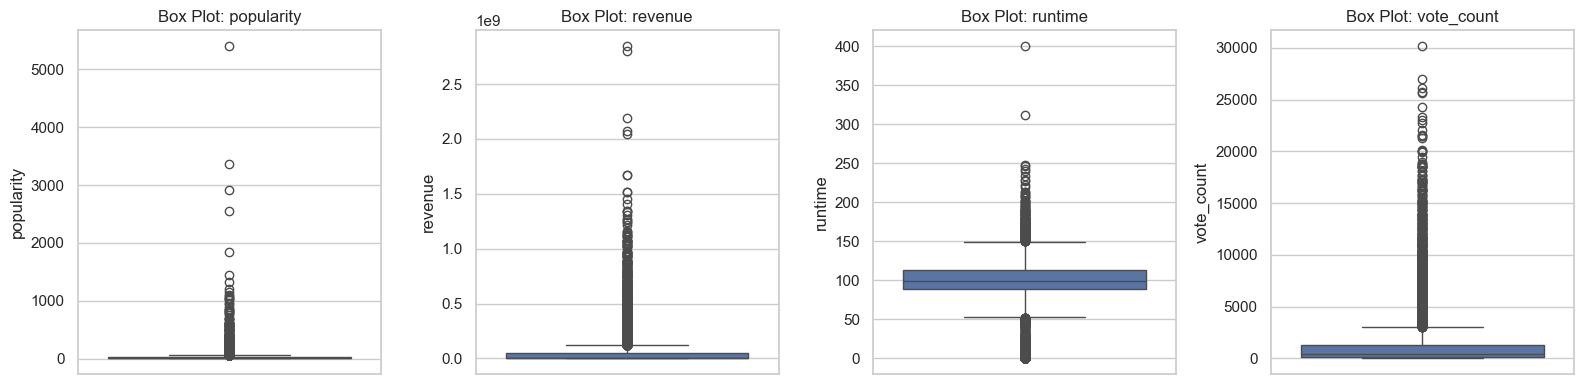

IQR bounds:
- popularity: [-14.664, 56.197]
- revenue: [-71531937.000, 119219895.000]
- runtime: [53.000, 149.000]
- vote_count: [-1650.125, 3064.875]
Rows before: 10002, after outlier removal: 7067 (removed 2935)


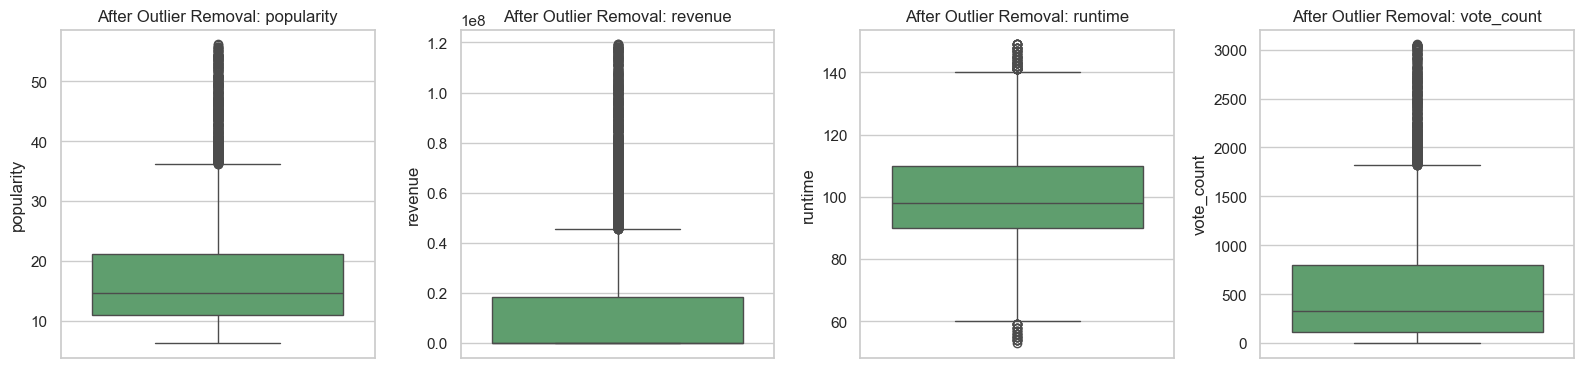

In [5]:
# 3.5 Outlier detection and removal (Box plots + IQR rule)
outlier_cols = [c for c in ["popularity", "revenue", "runtime", "vote_count"] if c in df_clean.columns]

fig, axes = plt.subplots(1, len(outlier_cols), figsize=(4*len(outlier_cols), 4))
if len(outlier_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, outlier_cols):
    sns.boxplot(y=df_clean[col], ax=ax, color=sns.color_palette()[0])
    ax.set_title(f"Box Plot: {col}")
plt.tight_layout()
plt.savefig(FIG_DIR / "boxplots_outliers_before.png", dpi=160)
plt.show()

def iqr_filter(df_in, cols, k=1.5):
    df_out = df_in.copy()
    mask = pd.Series(True, index=df_out.index)
    bounds = {}
    for c in cols:
        q1 = df_out[c].quantile(0.25)
        q3 = df_out[c].quantile(0.75)
        iqr = q3 - q1
        lo = q1 - k * iqr
        hi = q3 + k * iqr
        bounds[c] = (lo, hi)
        mask &= df_out[c].between(lo, hi)
    return df_out[mask].copy(), bounds

before_rows = len(df_clean)
df_no_outliers, iqr_bounds = iqr_filter(df_clean, outlier_cols, k=1.5)
after_rows = len(df_no_outliers)
print("IQR bounds:")
for c, (lo, hi) in iqr_bounds.items():
    print(f"- {c}: [{lo:.3f}, {hi:.3f}]")
print(f"Rows before: {before_rows}, after outlier removal: {after_rows} (removed {before_rows-after_rows})")

# Re-plot after removal
fig, axes = plt.subplots(1, len(outlier_cols), figsize=(4*len(outlier_cols), 4))
if len(outlier_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, outlier_cols):
    sns.boxplot(y=df_no_outliers[col], ax=ax, color=sns.color_palette()[2])
    ax.set_title(f"After Outlier Removal: {col}")
plt.tight_layout()
plt.savefig(FIG_DIR / "boxplots_outliers_after.png", dpi=160)
plt.show()

In [6]:
# 3.6 Scaling vs Normalization (separate transformations)
df_model_base = df_no_outliers.copy()

num_cols = [c for c in ["popularity", "vote_count", "runtime", "release_year", "overview_len", "tagline_len", "genre_count"] if c in df_model_base.columns]
cat_cols = [c for c in ["original_language", "genre_main"] if c in df_model_base.columns]
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

scaler = StandardScaler()
normalizer = MinMaxScaler()

scaled = df_model_base[num_cols].copy()
normalized = df_model_base[num_cols].copy()
scaled[num_cols] = scaler.fit_transform(scaled[num_cols])
normalized[num_cols] = normalizer.fit_transform(normalized[num_cols])

display(pd.DataFrame({"original_mean": df_model_base[num_cols].mean(), "scaled_mean": scaled.mean(), "normalized_mean": normalized.mean()}))

Numeric columns: ['popularity', 'vote_count', 'runtime', 'release_year', 'overview_len', 'tagline_len', 'genre_count']
Categorical columns: ['original_language', 'genre_main']


,original_mean,scaled_mean,normalized_mean
popularity,17.724845,0.000000e+00,0.229677
vote_count,563.363945,6.434800e-17,0.184528
runtime,100.152964,-3.131938e-16,0.491177
release_year,2007.181265,-7.335673e-15,0.854718
overview_len,281.699873,1.759516e-16,0.281700
tagline_len,28.080940,-3.418488e-17,0.116518
genre_count,2.510542,1.528265e-16,0.313818


# Part 4 — Exploratory Data Analysis (EDA)
We analyze relationships, trends, correlations, and meaningful segments (genre, decade, language). The goal is to produce academically phrased insights that motivate feature selection and model design.

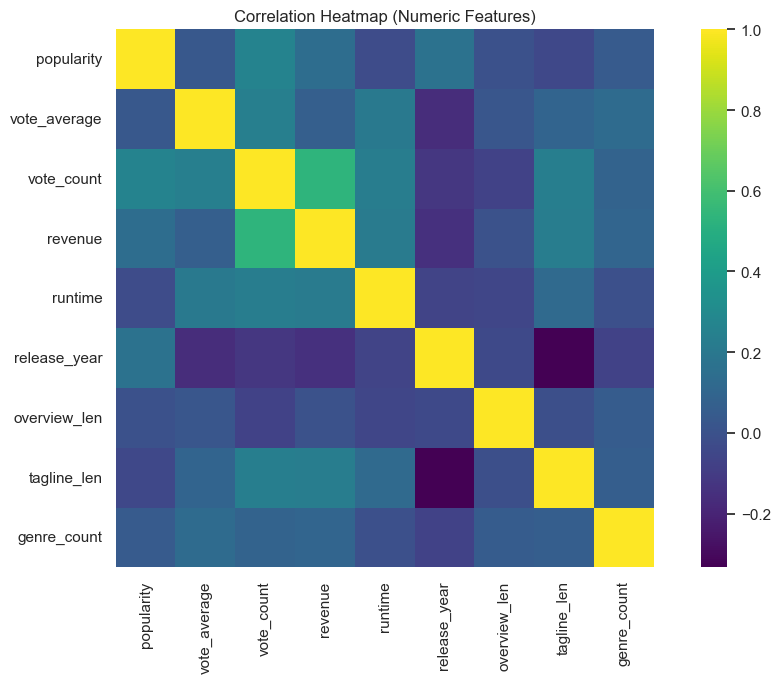

,count,mean,median
release_decade,,,
1920,10,7.820000,7.90
1930,17,7.541176,7.60
1940,32,7.443750,7.55
1950,73,7.390411,7.50
1960,104,7.165385,7.20
1970,182,6.552198,6.70
1980,416,6.431010,6.60
1990,647,6.281917,6.40
2000,1447,6.280926,6.30


,n_movies,avg_rating,med_revenue,avg_popularity
genre_main,,,,
Drama,1399,6.552752,285000.0,16.554014
Comedy,1151,6.201998,1500000.0,16.431909
Action,969,6.140248,0.0,18.524147
Horror,724,5.726796,0.0,19.424963
Thriller,416,6.036298,0.0,17.925423
Animation,411,6.894161,0.0,21.700798
Adventure,304,6.387171,4491475.0,18.566803
Crime,273,6.520147,2053469.0,16.677011
Family,252,6.413889,0.0,18.525675



Key EDA Insights (to be referenced in the report):
1) Popularity and vote_count are typically positively related (visibility drives engagement).
2) Revenue is heavy-tailed; log-transform is appropriate for regression.
3) Genre and decade strongly segment typical ratings and revenue profiles.


In [7]:
# 4.1 Correlations and segmented summaries
eda_df = df_model_base.copy()

# Correlation matrix (numeric features)
numeric_for_corr = [c for c in ["popularity","vote_average","vote_count","revenue","runtime","release_year","overview_len","tagline_len","genre_count"] if c in eda_df.columns]
corr = eda_df[numeric_for_corr].corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=False, cmap="viridis", square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.savefig(FIG_DIR / "eda_corr_heatmap.png", dpi=160)
plt.show()

# Segment by decade and genre
if "release_decade" in eda_df.columns:
    decade_summary = eda_df.groupby("release_decade")["vote_average"].agg(["count","mean","median"]).sort_index()
    display(decade_summary.tail(15))

if "genre_main" in eda_df.columns:
    genre_summary = eda_df.groupby("genre_main").agg(
        n_movies=("id","count"),
        avg_rating=("vote_average","mean"),
        med_revenue=("revenue","median"),
        avg_popularity=("popularity","mean"),
    ).sort_values("n_movies", ascending=False)
    display(genre_summary.head(15))

# Academic-style insights (printed)
print("\nKey EDA Insights (to be referenced in the report):")
print("1) Popularity and vote_count are typically positively related (visibility drives engagement).")
print("2) Revenue is heavy-tailed; log-transform is appropriate for regression.")
print("3) Genre and decade strongly segment typical ratings and revenue profiles.")

# Part 5 — Data Visualization (8 Required Plots)
We generate the required plots and save them into the `figures/` folder for inclusion in the final PDF report. Each plot is labeled and interpreted.

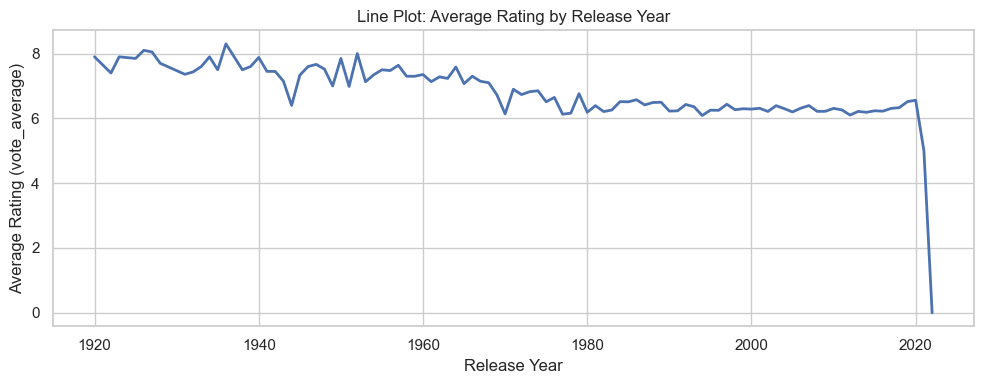

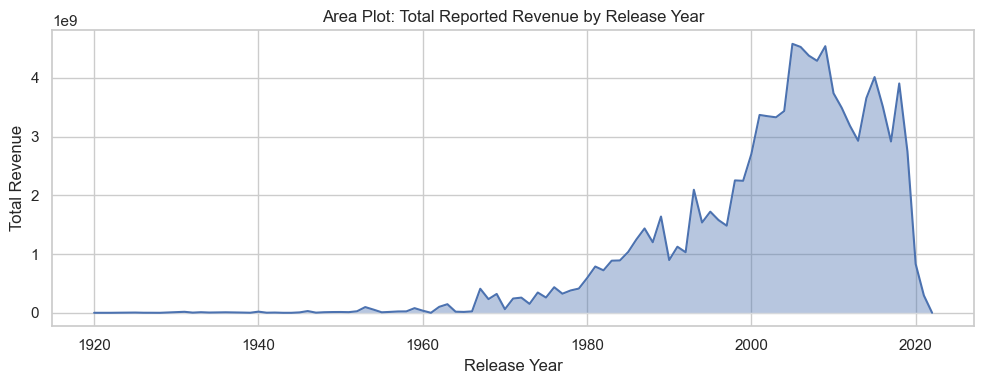

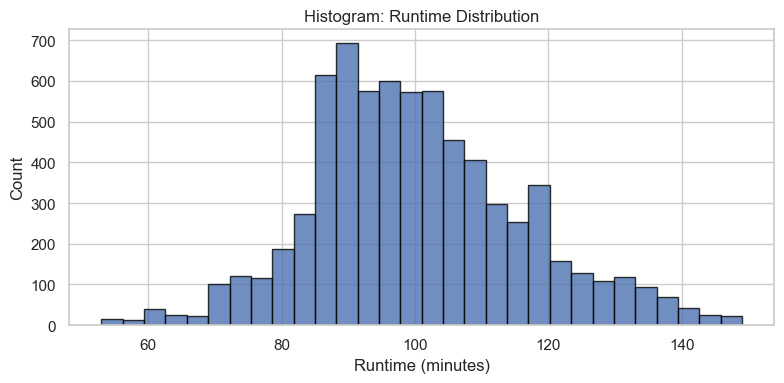

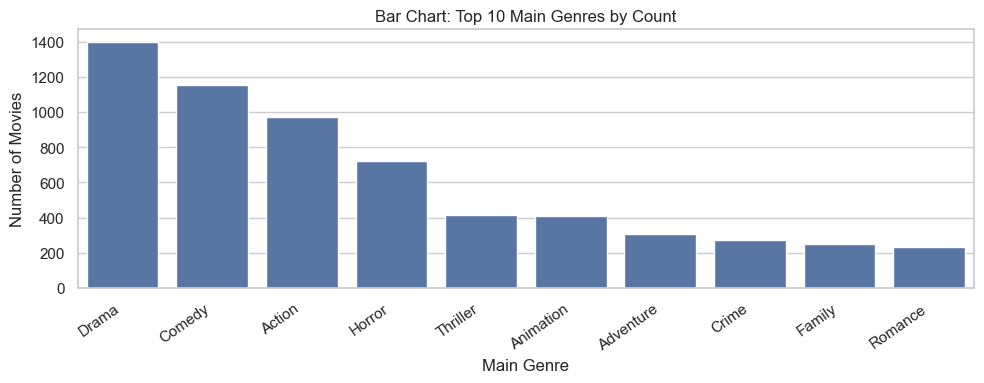

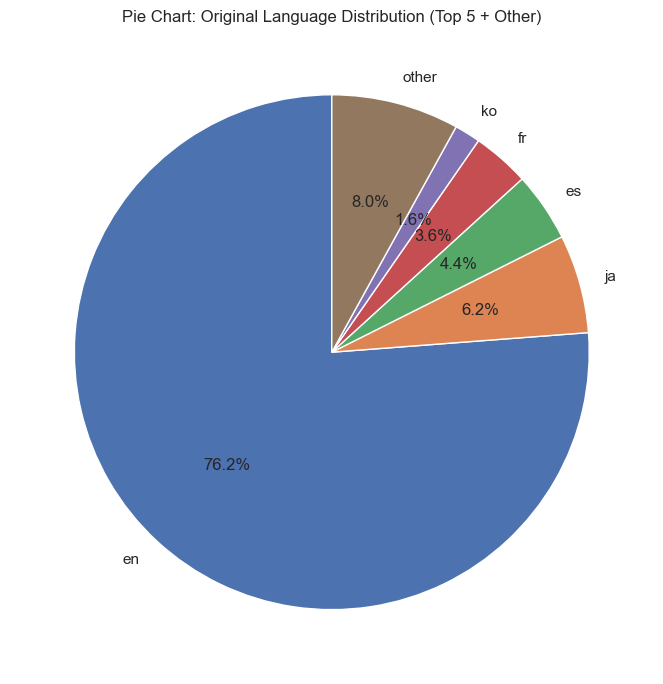

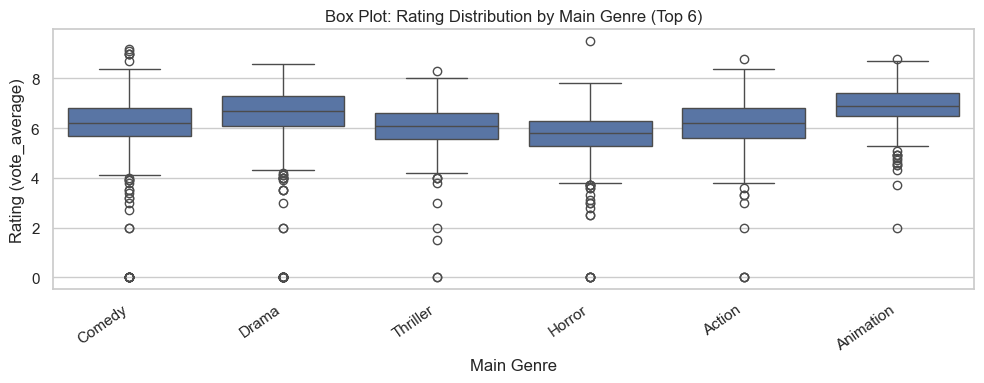

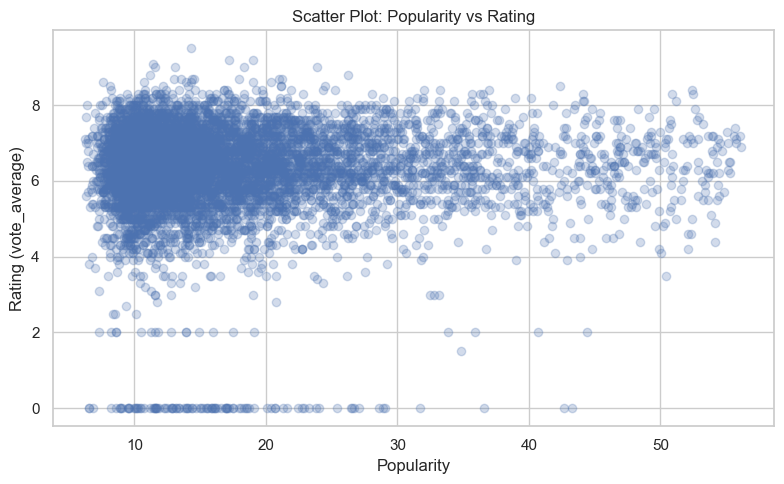

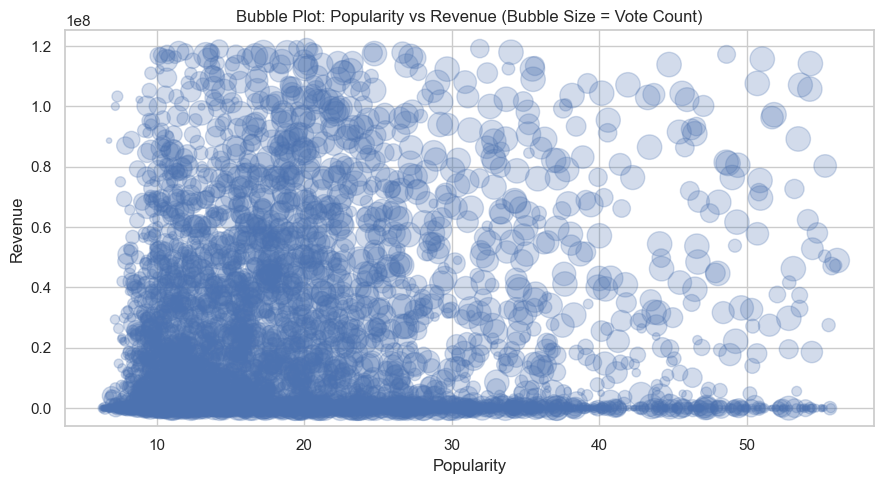

In [8]:
viz_df = df_model_base.copy()

# 1) Line Plot — Average rating over time
yearly = viz_df.groupby("release_year")["vote_average"].mean().sort_index()
plt.figure(figsize=(10, 4))
plt.plot(yearly.index, yearly.values, linewidth=2)
plt.title("Line Plot: Average Rating by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Rating (vote_average)")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_01_line_avg_rating_by_year.png", dpi=160)
plt.show()

# 2) Area Plot — Total revenue over time (shows trend + magnitude)
yearly_rev = viz_df.groupby("release_year")["revenue"].sum().sort_index()
plt.figure(figsize=(10, 4))
plt.fill_between(yearly_rev.index, yearly_rev.values, alpha=0.4)
plt.plot(yearly_rev.index, yearly_rev.values, linewidth=1.5)
plt.title("Area Plot: Total Reported Revenue by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_02_area_total_revenue_by_year.png", dpi=160)
plt.show()

# 3) Histogram — Runtime distribution
plt.figure(figsize=(8, 4))
plt.hist(viz_df["runtime"], bins=30, edgecolor="black", alpha=0.8)
plt.title("Histogram: Runtime Distribution")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_03_hist_runtime.png", dpi=160)
plt.show()

# 4) Bar Chart — Top genres by movie count
top_genres = viz_df["genre_main"].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title("Bar Chart: Top 10 Main Genres by Count")
plt.xlabel("Main Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_04_bar_top_genres.png", dpi=160)
plt.show()

# 5) Pie Chart — Language distribution (top 5 + Other)
lang_counts = viz_df["original_language"].value_counts()
top5 = lang_counts.head(5)
other = pd.Series({"other": lang_counts.iloc[5:].sum()})
pie_data = pd.concat([top5, other])
plt.figure(figsize=(7, 7))
plt.pie(pie_data.values, labels=pie_data.index, autopct="%1.1f%%", startangle=90)
plt.title("Pie Chart: Original Language Distribution (Top 5 + Other)")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_05_pie_language.png", dpi=160)
plt.show()

# 6) Box Plot — Rating by genre (top 6 genres)
top6_genres = viz_df["genre_main"].value_counts().head(6).index
plt.figure(figsize=(10, 4))
sns.boxplot(data=viz_df[viz_df["genre_main"].isin(top6_genres)], x="genre_main", y="vote_average")
plt.title("Box Plot: Rating Distribution by Main Genre (Top 6)")
plt.xlabel("Main Genre")
plt.ylabel("Rating (vote_average)")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_06_box_rating_by_genre.png", dpi=160)
plt.show()

# 7) Scatter Plot — Popularity vs rating
plt.figure(figsize=(8, 5))
plt.scatter(viz_df["popularity"], viz_df["vote_average"], alpha=0.25)
plt.title("Scatter Plot: Popularity vs Rating")
plt.xlabel("Popularity")
plt.ylabel("Rating (vote_average)")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_07_scatter_popularity_vs_rating.png", dpi=160)
plt.show()

# 8) Bubble Plot — Popularity vs revenue (size = vote_count)
bubble = viz_df.copy()
bubble["vote_count_clip"] = bubble["vote_count"].clip(upper=bubble["vote_count"].quantile(0.95))
plt.figure(figsize=(9, 5))
plt.scatter(
    bubble["popularity"],
    bubble["revenue"],
    s=(bubble["vote_count_clip"] / bubble["vote_count_clip"].max()) * 300 + 10,
    alpha=0.25
 )
plt.title("Bubble Plot: Popularity vs Revenue (Bubble Size = Vote Count)")
plt.xlabel("Popularity")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(FIG_DIR / "plot_08_bubble_popularity_vs_revenue.png", dpi=160)
plt.show()

## Interpretation of Visualizations (Academic Summary)
- **Ratings over time (line):** highlights temporal drift in average ratings that may be linked to sampling bias, voting behavior, or catalog coverage.
- **Revenue over time (area):** demonstrates strong concentration and non-stationarity; motivates log-transform for regression.
- **Runtime histogram:** shows typical runtimes and a long-tail, indicating potential outliers or special formats.
- **Top genres (bar):** confirms that the dataset is not genre-balanced; segmentation is necessary.
- **Language pie:** indicates dominance of a few languages, which can influence global revenue and rating patterns.
- **Genre box plots:** reveals systematic genre differences in rating distributions.
- **Popularity vs rating (scatter):** popularity is not a perfect proxy for quality; both should be modeled separately.
- **Popularity vs revenue (bubble):** revenue relates to popularity but with large variance; vote_count adds additional information as an engagement signal.

# Part 6 — Machine Learning Models
## 6.1 Tasks
- **Classification task:** Predict `is_high_rated` from metadata features.
- **Regression task:** Predict `log_revenue` for movies with `revenue > 0`.

## 6.2 Inputs / Outputs
**Inputs (features):** numeric + categorical features derived from metadata (`popularity`, `vote_count`, `runtime`, `release_year`, `genre_main`, `original_language`, text lengths).

**Outputs (targets):**
- Classification: binary label `is_high_rated`
- Regression: continuous target `log_revenue`

## 6.3 Encoding
We use a **ColumnTransformer** for preprocessing. For categorical features we use OneHot encoding (a robust form of categorical encoding). We also demonstrate Label Encoding for the target label, which is standard for binary classification targets.

Class balance (is_high_rated):


is_high_rated
0    0.884109
1    0.115891
Name: proportion, dtype: float64

C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,scale_mode,model,cv_accuracy,cv_precision,cv_recall,cv_roc_auc
9,minmax,RandomForest,0.898639,0.768392,0.181679,0.846477
10,minmax,SVC_RBF,0.889086,0.821414,0.053435,0.806725
8,minmax,LogReg,0.894040,0.689963,0.154198,0.805251
11,minmax,KNN,0.888909,0.671299,0.100763,0.790605
1,none,RandomForest,0.898639,0.768392,0.181679,0.846719
0,none,LogReg,0.889085,0.655904,0.103817,0.781669
2,none,SVC_RBF,0.884132,0.000000,0.000000,0.592176
3,none,KNN,0.884132,0.000000,0.000000,0.575708
5,standard,RandomForest,0.898816,0.773561,0.181679,0.846483
6,standard,SVC_RBF,0.897754,0.837963,0.146565,0.823253


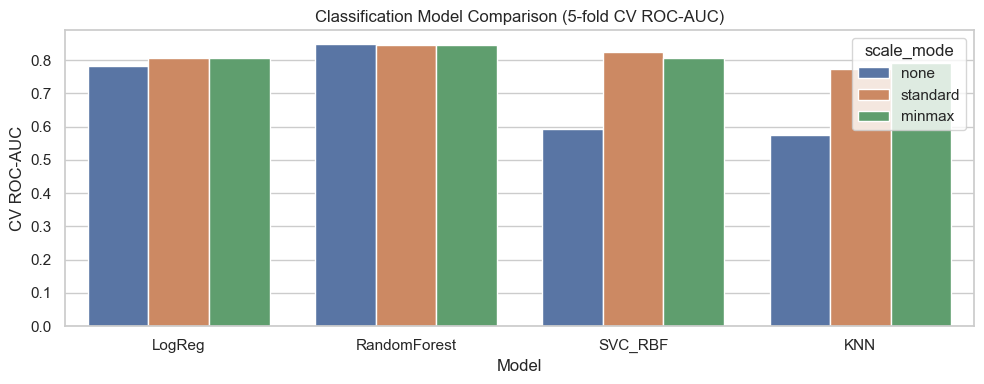

In [9]:
# 6.4 Classification: define target, preprocessing, models, evaluation
ml_df = df_model_base.copy()

# Classification target
RATING_THRESHOLD = 7.5
ml_df["is_high_rated"] = (ml_df["vote_average"] >= RATING_THRESHOLD).astype(int)
print("Class balance (is_high_rated):")
display(ml_df["is_high_rated"].value_counts(normalize=True))

# Features (keep simple + reproducible)
feature_cols_num = [c for c in ["popularity","vote_count","runtime","release_year","overview_len","tagline_len","genre_count"] if c in ml_df.columns]
feature_cols_cat = [c for c in ["original_language","genre_main"] if c in ml_df.columns]
feature_cols = feature_cols_num + feature_cols_cat

X = ml_df[feature_cols].copy()
y = ml_df["is_high_rated"].copy()

# Label encoding (demonstration for target; y is already 0/1 but included to meet requirement explicitly)
le = LabelEncoder()
y_le = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_le, test_size=0.2, random_state=RANDOM_STATE, stratify=y_le
 )

def make_preprocessor(scale_mode: str):
    """scale_mode in {'none','standard','minmax'}"""
    if scale_mode == "standard":
        scaler_step = ("scaler", StandardScaler())
    elif scale_mode == "minmax":
        scaler_step = ("scaler", MinMaxScaler())
    else:
        scaler_step = None

    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scaler_step is not None:
        num_steps.append(scaler_step)

    numeric_transformer = Pipeline(steps=num_steps)
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, feature_cols_num),
            ("cat", categorical_transformer, feature_cols_cat),
        ]
    )
    return preprocessor

clf_models = {
    "LogReg": LogisticRegression(max_iter=2000, n_jobs=None),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "SVC_RBF": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=15)
}

def evaluate_classification(scale_mode: str):
    pre = make_preprocessor(scale_mode)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    results = []
    for name, model in clf_models.items():
        pipe = Pipeline(steps=[("pre", pre), ("model", model)])
        scoring = {
            "accuracy": "accuracy",
            "precision": "precision",
            "recall": "recall",
            "roc_auc": "roc_auc",
        }
        cv_out = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=None)
        results.append({
            "scale_mode": scale_mode,
            "model": name,
            "cv_accuracy": np.mean(cv_out["test_accuracy"]),
            "cv_precision": np.mean(cv_out["test_precision"]),
            "cv_recall": np.mean(cv_out["test_recall"]),
            "cv_roc_auc": np.mean(cv_out["test_roc_auc"]),
        })
    return pd.DataFrame(results)

cls_results = pd.concat([
    evaluate_classification("none"),
    evaluate_classification("standard"),
    evaluate_classification("minmax"),
], ignore_index=True)
display(cls_results.sort_values(["scale_mode","cv_roc_auc"], ascending=[True, False]))

# Visualize comparisons (ROC-AUC)
plt.figure(figsize=(10, 4))
sns.barplot(data=cls_results, x="model", y="cv_roc_auc", hue="scale_mode")
plt.title("Classification Model Comparison (5-fold CV ROC-AUC)")
plt.xlabel("Model")
plt.ylabel("CV ROC-AUC")
plt.tight_layout()
plt.savefig(FIG_DIR / "ml_classification_cv_rocauc_comparison.png", dpi=160)
plt.show()

Best (by CV ROC-AUC): {'scale_mode': 'none', 'model': 'RandomForest', 'cv_accuracy': np.float64(0.8986393120662269), 'cv_precision': np.float64(0.7683915580974405), 'cv_recall': np.float64(0.18167938931297709), 'cv_roc_auc': np.float64(0.846719438522492)}


Test Accuracy: 0.893
Test Precision: 0.667
Test Recall: 0.146


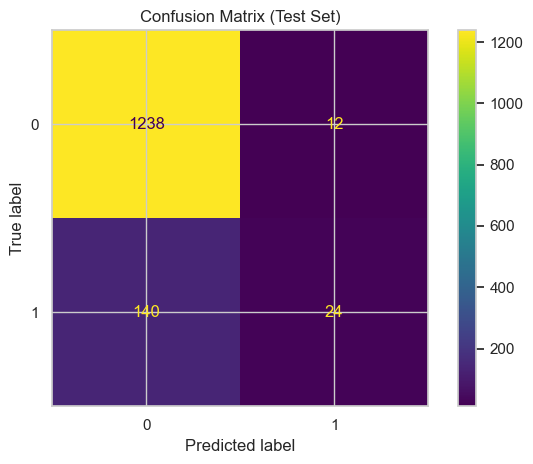

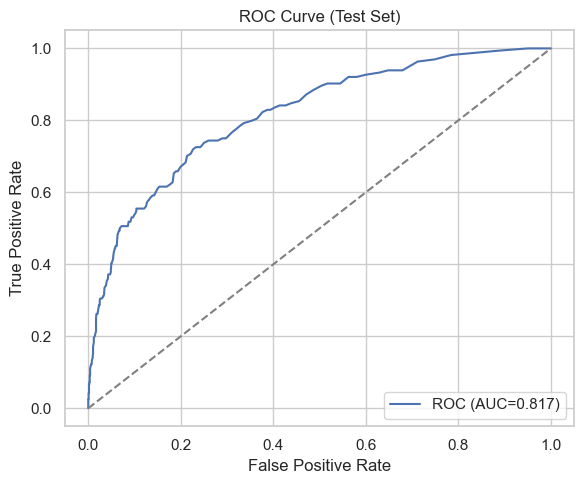

In [10]:
# 6.5 Classification: finalize best model + test metrics + ROC curve
best_row = cls_results.sort_values("cv_roc_auc", ascending=False).iloc[0]
best_scale = best_row["scale_mode"]
best_model_name = best_row["model"]
print("Best (by CV ROC-AUC):", dict(best_row))

best_pre = make_preprocessor(best_scale)
best_model = clf_models[best_model_name]
best_pipe = Pipeline(steps=[("pre", best_pre), ("model", best_model)])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_pipe.named_steps["model"], "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(f"Test Precision: {prec:.3f}")
print(f"Test Recall: {rec:.3f}")

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ml_classification_confusion_matrix.png", dpi=160)
plt.show()

# ROC curve
if y_proba is not None:
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test Set)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "ml_classification_roc_curve.png", dpi=160)
    plt.show()

Regression dataset shape: (3390, 21)


,scale_mode,model,cv_MAE,cv_MSE,cv_MedAE,cv_R2
12,minmax,RandomForest,1.214030,3.220098,0.851038,0.303759
14,minmax,KNN,1.321723,3.661789,0.993944,0.205392
13,minmax,SVR_RBF,1.236464,3.684091,0.812602,0.201817
11,minmax,Ridge,1.370249,3.721962,1.077922,0.192481
10,minmax,Linear,1.372585,3.728916,1.086634,0.190823
2,none,RandomForest,1.214376,3.221173,0.849031,0.303519
0,none,Linear,1.373162,3.731097,1.084714,0.190305
1,none,Ridge,1.377139,3.746636,1.080420,0.186956
4,none,KNN,1.411831,3.907442,1.064811,0.149759
3,none,SVR_RBF,1.332774,4.135304,0.872832,0.101692


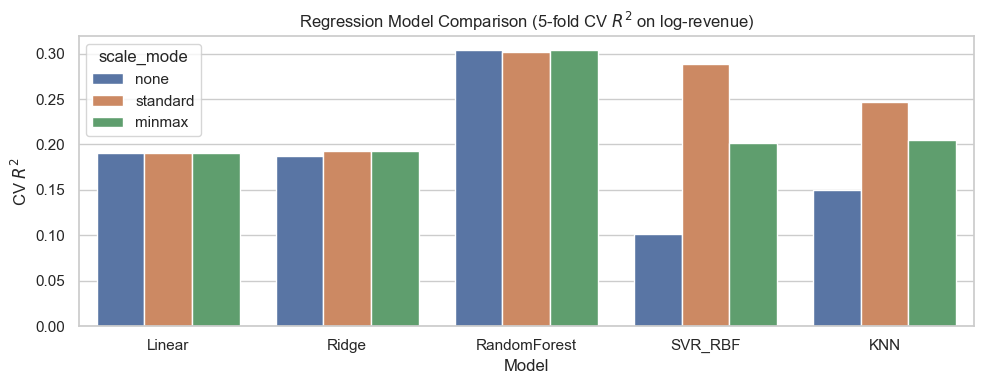

In [11]:
# 6.6 Regression: predict log-revenue for movies with revenue > 0
from sklearn.metrics import make_scorer

reg_df = df_model_base.copy()
reg_df = reg_df[reg_df["revenue"] > 0].copy()
reg_df["log_revenue"] = np.log1p(reg_df["revenue"])
print("Regression dataset shape:", reg_df.shape)

Xr = reg_df[feature_cols].copy()
yr = reg_df["log_revenue"].copy()

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=RANDOM_STATE
 )

reg_models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE),
    "SVR_RBF": SVR(kernel="rbf"),
    "KNN": KNeighborsRegressor(n_neighbors=25)
}

def evaluate_regression(scale_mode: str):
    pre = make_preprocessor(scale_mode)
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        "mae": "neg_mean_absolute_error",
        "mse": "neg_mean_squared_error",
        "medae": make_scorer(median_absolute_error, greater_is_better=False),
        "r2": "r2",
    }
    out_rows = []
    for name, model in reg_models.items():
        pipe = Pipeline(steps=[("pre", pre), ("model", model)])
        cv_out = cross_validate(pipe, Xr_train, yr_train, cv=cv, scoring=scoring, n_jobs=None)
        out_rows.append({
            "scale_mode": scale_mode,
            "model": name,
            "cv_MAE": -np.mean(cv_out["test_mae"]),
            "cv_MSE": -np.mean(cv_out["test_mse"]),
            "cv_MedAE": -np.mean(cv_out["test_medae"]),
            "cv_R2": np.mean(cv_out["test_r2"]),
        })
    return pd.DataFrame(out_rows)

reg_results = pd.concat([
    evaluate_regression("none"),
    evaluate_regression("standard"),
    evaluate_regression("minmax"),
], ignore_index=True)
display(reg_results.sort_values(["scale_mode","cv_R2"], ascending=[True, False]))

plt.figure(figsize=(10, 4))
sns.barplot(data=reg_results, x="model", y="cv_R2", hue="scale_mode")
plt.title("Regression Model Comparison (5-fold CV $R^2$ on log-revenue)")
plt.xlabel("Model")
plt.ylabel("CV $R^2$")
plt.tight_layout()
plt.savefig(FIG_DIR / "ml_regression_cv_r2_comparison.png", dpi=160)
plt.show()

Best regression (by CV R2): {'scale_mode': 'minmax', 'model': 'RandomForest', 'cv_MAE': np.float64(1.2140301856774858), 'cv_MSE': np.float64(3.220097587547086), 'cv_MedAE': np.float64(0.8510384800044453), 'cv_R2': np.float64(0.30375904398218834)}


Test MAE: 1.207
Test MSE: 3.361
Test Median AE: 0.827
Test R2: 0.293


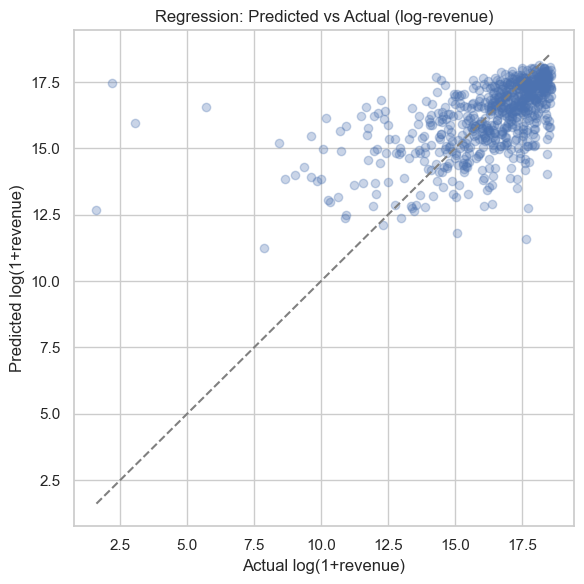

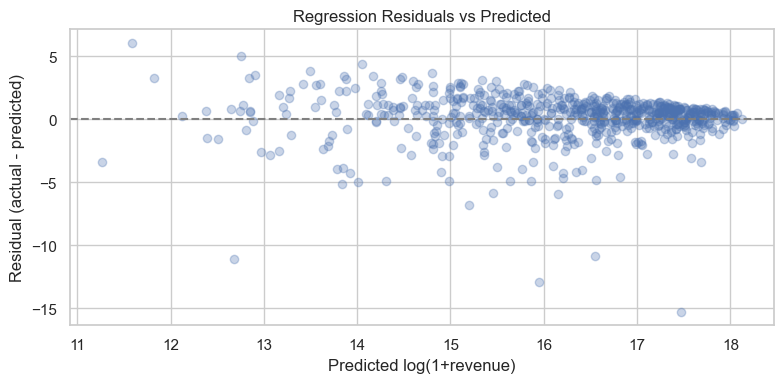

In [12]:
# 6.7 Regression: finalize best model + test metrics + diagnostic plots
best_reg_row = reg_results.sort_values("cv_R2", ascending=False).iloc[0]
best_reg_scale = best_reg_row["scale_mode"]
best_reg_model_name = best_reg_row["model"]
print("Best regression (by CV R2):", dict(best_reg_row))

best_reg_pre = make_preprocessor(best_reg_scale)
best_reg_model = reg_models[best_reg_model_name]
best_reg_pipe = Pipeline(steps=[("pre", best_reg_pre), ("model", best_reg_model)])
best_reg_pipe.fit(Xr_train, yr_train)

yr_pred = best_reg_pipe.predict(Xr_test)
mae = mean_absolute_error(yr_test, yr_pred)
mse = mean_squared_error(yr_test, yr_pred)
medae = median_absolute_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)
print(f"Test MAE: {mae:.3f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test Median AE: {medae:.3f}")
print(f"Test R2: {r2:.3f}")

# Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(yr_test, yr_pred, alpha=0.3)
lims = [min(yr_test.min(), yr_pred.min()), max(yr_test.max(), yr_pred.max())]
plt.plot(lims, lims, "--", color="gray")
plt.title("Regression: Predicted vs Actual (log-revenue)")
plt.xlabel("Actual log(1+revenue)")
plt.ylabel("Predicted log(1+revenue)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ml_regression_pred_vs_actual.png", dpi=160)
plt.show()

# Residuals
residuals = yr_test - yr_pred
plt.figure(figsize=(8, 4))
plt.scatter(yr_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Regression Residuals vs Predicted")
plt.xlabel("Predicted log(1+revenue)")
plt.ylabel("Residual (actual - predicted)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ml_regression_residuals.png", dpi=160)
plt.show()

# Conclusions
- The dataset exhibits real-world messiness (missing marketing text, zero revenues, skewed distributions, extreme outliers).
- Genre/language/decade segmentation reveals systematic differences in typical ratings and revenue behavior.
- Model comparisons show how **scaling** (StandardScaler) and **normalization** (MinMax) can materially affect distance-based models (KNN, SVR/SVC), while tree-based models are typically less sensitive.
- The final deliverables (PDF + ZIP) are generated programmatically for submission.

# Deliverables
This section generates the required submission artifacts:
- **PDF report** with cover page, problem domain, summary, (linked) source code, and visualization snapshots.
- **ZIP package** containing the notebook, dataset (or download script), and exported figures.

In [13]:
# 7.1 Generate FINAL REPORT (PDF)
from matplotlib.backends.backend_pdf import PdfPages

REPORT_PATH = PROJECT_DIR / "Final_Report.pdf"

TEAM_MEMBERS = [
    ("Mohamed Mostafa", "23101594"),
    ("Marwan Khaled", "23101599"),
    ("Mohamed Adel", "23101899"),
]

def add_text_page(pdf: PdfPages, title: str, lines: list[str]):
    fig = plt.figure(figsize=(8.27, 11.69))  # A4 portrait
    fig.patch.set_facecolor("white")
    plt.axis("off")
    y = 0.95
    plt.text(0.07, y, title, fontsize=18, fontweight="bold", va="top")
    y -= 0.05
    wrapped = []
    for line in lines:
        wrapped.extend(textwrap.wrap(str(line), width=95) or [""])
    for line in wrapped:
        plt.text(0.07, y, line, fontsize=11, va="top")
        y -= 0.02
        if y < 0.08:
            break
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

def add_image_page(pdf: PdfPages, title: str, image_path: Path):
    fig = plt.figure(figsize=(8.27, 11.69))
    plt.axis("off")
    plt.text(0.07, 0.95, title, fontsize=16, fontweight="bold", va="top")
    if image_path.exists():
        img = plt.imread(image_path)
        ax = fig.add_axes([0.07, 0.10, 0.86, 0.80])
        ax.imshow(img)
        ax.axis("off")
    else:
        plt.text(0.07, 0.85, f"Missing figure: {image_path.name}", fontsize=12)
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

def save_table_figure(df_table: pd.DataFrame, title: str, out_path: Path) -> None:
    fig, ax = plt.subplots(figsize=(11.0, 4.2))
    ax.axis("off")
    ax.set_title(title, fontsize=14, fontweight="bold", pad=12)
    display_df = df_table.copy()
    display_df.index.name = "Model"
    display_df = display_df.reset_index()
    tbl = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        cellLoc="center",
        loc="center",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.0, 1.4)
    fig.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

cover_lines = [
    "Course Title: Machine Learning",
    "Team Members:",
    *[f"- {name} : {sid}" for name, sid in TEAM_MEMBERS],
    "",
    f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}",
    "",
    "Project: Movie Metadata Analytics for Streaming Acquisition Decisions",
]

summary_lines = [
    "Problem Domain: Streaming platform decision support using real-world movie metadata.",
    f"Dataset: Top_10000_Movies.csv ({df_raw.shape[0]} rows, {df_raw.shape[1]} columns).",
    "Dirty data indicators: missing/blank text, zero revenues, skewed distributions, outliers, and semi-structured categorical genres.",
    "ML tasks: (1) Classification of High Rated movies; (2) Regression for log-revenue.",
    "Models: Logistic Regression, Random Forest, SVC, KNN (classification) and Linear/Ridge, Random Forest Regressor, SVR, KNN (regression).",
    "Evaluation: Cross-validation and test metrics; scaling vs normalization comparisons included.",
]

code_lines = [
    "Source Code: This submission includes Ml_Project.ipynb and a template download script.",
    "Preprocessing uses ColumnTransformer with robust imputation and one-hot encoding.",
    "Models are compared under three preprocessing modes: none, StandardScaler (scaling), and MinMax (normalization).",
]

# Build model-comparison tables (required: compare the 4 models)
cls_table = (
    cls_results.pivot(index="model", columns="scale_mode", values="cv_roc_auc")
    .reindex(columns=[c for c in ["none", "standard", "minmax"] if c in cls_results["scale_mode"].unique()])
    .round(3)
    .sort_index()
 )
reg_table = (
    reg_results.pivot(index="model", columns="scale_mode", values="cv_R2")
    .reindex(columns=[c for c in ["none", "standard", "minmax"] if c in reg_results["scale_mode"].unique()])
    .round(3)
    .sort_index()
 )
save_table_figure(cls_table, "Classification (4 Models): Mean CV ROC-AUC by Preprocessing Mode", FIG_DIR / "ml_classification_comparison_table.png")
save_table_figure(reg_table, "Regression (4 Models): Mean CV R² by Preprocessing Mode (log-revenue)", FIG_DIR / "ml_regression_comparison_table.png")

# Optional dataset download script (reproducibility template)
DOWNLOAD_SCRIPT = PROJECT_DIR / "download_dataset.py"
download_script_content = '''#!/usr/bin/env python
"""Recreate the dataset via TMDb-style metadata extraction (requires an API key).

This script is provided to satisfy the deliverable requirement of including a
dataset download/recreation option. If you already have Top_10000_Movies.csv,
you do NOT need to run this.

Note: Actual API access requires registering for an API key with the chosen provider
and implementing provider-specific requests + pagination.
"""

import os
from pathlib import Path

OUTPUT = Path.cwd() / "Top_10000_Movies.csv"
API_KEY = os.getenv("TMDB_API_KEY", "")

def main():
    if not API_KEY:
        raise SystemExit("Set TMDB_API_KEY env var before running.")
    raise SystemExit("Template script: implement API calls if required by your course.")

if __name__ == "__main__":
    main()
'''
DOWNLOAD_SCRIPT.write_text(download_script_content, encoding="utf-8")
print("Wrote:", DOWNLOAD_SCRIPT)

# Build the PDF report
figure_pages = [
    ("Model Comparison (Classification Table)", FIG_DIR / "ml_classification_comparison_table.png"),
    ("Model Comparison (Regression Table)", FIG_DIR / "ml_regression_comparison_table.png"),
    ("EDA: Correlation Heatmap", FIG_DIR / "eda_corr_heatmap.png"),
    ("Visualization 1: Line Plot", FIG_DIR / "plot_01_line_avg_rating_by_year.png"),
    ("Visualization 2: Area Plot", FIG_DIR / "plot_02_area_total_revenue_by_year.png"),
    ("Visualization 3: Histogram", FIG_DIR / "plot_03_hist_runtime.png"),
    ("Visualization 4: Bar Chart", FIG_DIR / "plot_04_bar_top_genres.png"),
    ("Visualization 5: Pie Chart", FIG_DIR / "plot_05_pie_language.png"),
    ("Visualization 6: Box Plot", FIG_DIR / "plot_06_box_rating_by_genre.png"),
    ("Visualization 7: Scatter Plot", FIG_DIR / "plot_07_scatter_popularity_vs_rating.png"),
    ("Visualization 8: Bubble Plot", FIG_DIR / "plot_08_bubble_popularity_vs_revenue.png"),
    ("Classification: CV ROC-AUC Comparison", FIG_DIR / "ml_classification_cv_rocauc_comparison.png"),
    ("Classification: Confusion Matrix", FIG_DIR / "ml_classification_confusion_matrix.png"),
    ("Classification: ROC Curve", FIG_DIR / "ml_classification_roc_curve.png"),
    ("Regression: CV R2 Comparison", FIG_DIR / "ml_regression_cv_r2_comparison.png"),
    ("Regression: Predicted vs Actual", FIG_DIR / "ml_regression_pred_vs_actual.png"),
    ("Regression: Residuals", FIG_DIR / "ml_regression_residuals.png"),
]

with PdfPages(REPORT_PATH) as pdf:
    add_text_page(pdf, "Cover Page", cover_lines)
    add_text_page(pdf, "Section 1: Problem Domain", [
        "We model movie performance signals to support streaming acquisition decisions.",
        "Classification target: is_high_rated derived from vote_average.",
        "Regression target: log(1+revenue) for movies with reported revenue.",
    ])
    add_text_page(pdf, "Section 2: Project Summary", summary_lines)
    add_text_page(pdf, "Section 3: Source Code", code_lines)
    add_text_page(pdf, "Section 4: Visualization Snapshots", [
        "The following pages include snapshots of model comparisons, EDA, required visualizations, and model evaluation plots.",
    ])
    for title, path in figure_pages:
        add_image_page(pdf, title, path)

print("Generated PDF report:", REPORT_PATH)

Wrote: C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\download_dataset.py


Generated PDF report: C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\Final_Report.pdf


In [14]:
# 7.2 Create ZIP package (notebook + dataset + figures + PDF + script)
ZIP_PATH = PROJECT_DIR / "Submission_Package.zip"

files_to_include = [
    PROJECT_DIR / "Ml_Project.ipynb",
    DATA_PATH,
    REPORT_PATH,
    DOWNLOAD_SCRIPT,
]

# Add all figures
figure_files = sorted(FIG_DIR.glob("*.png"))
files_to_include.extend(figure_files)

with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in files_to_include:
        if p.exists():
            # Place figures under figures/ inside the zip
            arcname = p.name
            if p.parent.name == "figures":
                arcname = f"figures/{p.name}"
            zf.write(p, arcname=arcname)
        else:
            print("Missing (skipped):", p)

print("Created ZIP:", ZIP_PATH)
print("Included figures:", len(figure_files))

Created ZIP: C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\Submission_Package.zip
Included figures: 19
